In [1]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader
import umap
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertModel
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

2023-11-30 18:48:13.605907: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 18:48:13.658123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
# 데이터 로드
in_domain = pd.read_csv('indomain_food2.csv')  # in_domain 데이터
ood = pd.read_csv('ood_hospital2.csv')  # out_of_domain 데이터

In [69]:
in_domain = in_domain.iloc[:100000]
ood = ood.iloc[:100000]

In [70]:
from transformers import EncoderDecoderModel, BertTokenizerFast
from sentence_transformers import SentenceTransformer, models

# Load the full Encoder-Decoder model
full_model = EncoderDecoderModel.from_pretrained('kykim/bertshared-kor-base')

# Extract the Encoder part and save it
encoder = full_model.encoder
encoder.save_pretrained('kykim/bertshared-kor-base-encoder')

# Save the corresponding tokenizer as well
tokenizer = BertTokenizerFast.from_pretrained('kykim/bertshared-kor-base')
tokenizer.save_pretrained('kykim/bertshared-kor-base-encoder')

# Now you can use the Encoder part with Sentence-Transformers
word_embedding_model = models.Transformer('kykim/bertshared-kor-base-encoder')

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Save the model
model.save("kykim/bertshared-kor-base-sentence-transformer")

# Load the model
model = SentenceTransformer("kykim/bertshared-kor-base-sentence-transformer")


The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [71]:
# DataLoader 생성
train_examples = [InputExample(texts=[anchor, positive, negative]) for anchor, positive, negative in zip(in_domain['발화문'], in_domain['발화문'], ood['발화문'])]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [72]:
# TripletLoss 정의 및 모델 학습
train_loss = losses.TripletLoss(model=model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=100)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3158 [00:00<?, ?it/s]

In [73]:
# 임베딩 생성 및 UMAP으로 2차원으로 축소
in_domain_embeddings = model.encode(in_domain['발화문'].tolist())
ood_embeddings = model.encode(ood['발화문'].tolist())

reducer = umap.UMAP()
in_domain_embeddings_2d = reducer.fit_transform(in_domain_embeddings)
ood_embeddings_2d = reducer.fit_transform(ood_embeddings)

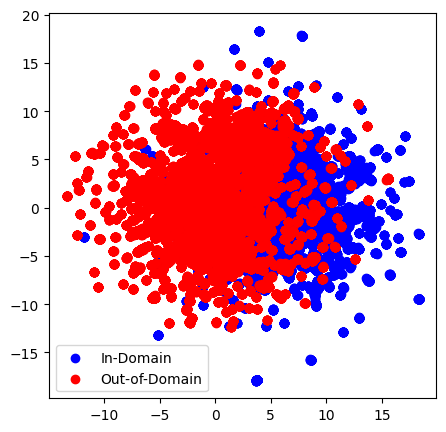

In [78]:
# 시각화
plt.figure(figsize=(5, 5))
plt.scatter(in_domain_embeddings_2d[:, 0], in_domain_embeddings_2d[:, 1], color='blue', label='In-Domain')
plt.scatter(ood_embeddings_2d[:, 0], ood_embeddings_2d[:, 1], color='red', label='Out-of-Domain')
plt.legend()
plt.show()

In [75]:
from sklearn.neighbors import NearestNeighbors

In [79]:
# Faiss 인덱스 생성
def create_nn_index(embeddings):
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(embeddings)
    return nn

# 가장 가까운 이웃 찾기
def find_nearest_neighbor(query_embedding, nn):
    distances, indices = nn.kneighbors(query_embedding)
    return distances, indices

def get_query_embedding(query):
    query_embedding = model.encode([query])[0]  # 쿼리를 임베딩하고, 결과를 2차원 배열에서 1차원 배열로 변환
    return query_embedding.reshape(1, -1)  # 임베딩을 2차원 배열로 변환


# 인덱스 생성
in_domain_index = create_nn_index(in_domain_embeddings)
ood_index = create_nn_index(ood_embeddings)

# 쿼리
query = input()
query_embedding = get_query_embedding(query)

# 각 클래스에서 가장 가까운 이웃 찾기
in_domain_distances, in_domain_indices = find_nearest_neighbor(query_embedding, in_domain_index)
ood_distances, ood_indices = find_nearest_neighbor(query_embedding, ood_index)

# 둘 중에서 더 가까운 클래스 판단 및 출력
if in_domain_distances[0][0] < ood_distances[0][0]:
    print("이 쿼리는 in-domain에 더 가깝습니다.")
else:
    print("이 쿼리는 out-of-domain에 더 가깝습니다.")

 배달 되나요?


이 쿼리는 in-domain에 더 가깝습니다.


In [76]:
from sentence_transformers import util
import torch

def find_most_similar(query_embedding, corpus_embeddings):
    # 코사인 유사성 계산
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)
    
    # 가장 높은 유사성 점수를 가진 이웃 찾기
    top_results = torch.topk(cos_scores, k=1)
    return top_results.values, top_results.indices

def get_query_embedding(query):
    query_embedding = model.encode([query])[0]  # 쿼리를 임베딩하고, 결과를 2차원 배열에서 1차원 배열로 변환
    return query_embedding.reshape(1, -1)  # 임베딩을 2차원 배열로 변환

while True:
    # 쿼리
    query = input()
    if query == "":
        break
    query_embedding = get_query_embedding(query)
    
    # 각 클래스에서 가장 가까운 이웃 찾기
    in_domain_scores, in_domain_indices = find_most_similar(query_embedding, in_domain_embeddings)
    ood_scores, ood_indices = find_most_similar(query_embedding, ood_embeddings)
    
    # 둘 중에서 더 가까운 클래스 판단 및 출력
    if in_domain_scores[0].item() > ood_scores[0].item():  # 코사인 유사성은 높을수록 가깝다는 것을 의미하므로, '>' 연산자를 사용
        print("이 쿼리는 in-domain에 더 가깝습니다. 코사인 유사성 점수: {:.4f}".format(in_domain_scores[0].item()))
    else:
        print("이 쿼리는 out-of-domain에 더 가깝습니다. 코사인 유사성 점수: {:.4f}".format(ood_scores[0].item()))


 짜장면 배달되나요?


이 쿼리는 in-domain에 더 가깝습니다. 코사인 유사성 점수: 0.9420


In [62]:
import numpy as np

d = 64
nb = 100
nq = 10
np.random.seed(1234)
xb = np.random.random((nb, d)).astype("float32")
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype("float32")
xq[:, 0] += np.arange(nq) / 1000.

In [ ]:
import faiss
index = faiss.IndexFlatL2(d)
print(index.is_trained)
index.add(xb)

k = 4
D, I =index.search(xq, k)
print(I[:5])
print(I[-5:])